<a href="https://colab.research.google.com/github/hemekci/PythonforFinance/blob/main/Credits.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#0 - Preprocess

In [ ]:
!pip install graphviz


In [ ]:
from google.colab import drive
import pandas as pd

# Mount Google Drive to Colab
drive.mount('/content/drive')

basedir = "/content/drive/MyDrive/ColabData/CreditData"

# Read CSV file into DataFrame. Replace with your actual file path
df_credit = pd.read_csv( basedir + '/Credit_Decisions_Oct_2023.csv')
df_demography = pd.read_csv( basedir + '/Demographics_Oct_2023.csv')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
print(df_credit.shape)
df_credit.head()

(80057, 4)


,application_key,mvar1,decision,decision_amount
0,NaN,NaN,NaN,NaN
1,230032.0,1681.5,0.0,0.000000
2,230033.0,1804.5,1.0,1363.758814
3,230034.0,1732.5,1.0,1022.493980
4,230035.0,1726.5,1.0,998.246261


### Handling Missing Values

I need to decide impute or delete missing values.

In [ ]:
print(df_credit.isnull().sum())


application_key    0
mvar1              0
decision           0
decision_amount    0
dtype: int64


In [ ]:
missing_percentage = (df_credit.isnull().sum() / len(df_credit)) * 100
missing_percentage

application_key    0.0
mvar1              0.0
decision           0.0
decision_amount    0.0
dtype: float64


Given:  
*   no concentration of missing values in a few variables
*   the potential introduction of bias through imputation
*   small proportion of variables (4.6%) is missing, I have large enough dataset.
I prefer **removal of missing values over their imputation**

In [ ]:
# Deleting missing values from 'df_credit'
df_credit.dropna(subset=['application_key', 'mvar1', 'decision', 'decision_amount'], inplace=True)


In [ ]:
df_credit.shape

(76375, 4)


### Handling Duplicates

After find dublicated application_key values, I need to decide keep first, keep all or delete all

In [ ]:
unique_application_keys = df_credit['application_key'].nunique()
print(f"Number of unique application keys in df_credit: {unique_application_keys}")
non_unique_count = df_credit.duplicated().sum()
print("Number of non-unique (duplicate) rows in df_credit:", non_unique_count)


Number of unique application keys in df_credit: 76322
Number of non-unique (duplicate) rows in df_credit: 15


In [ ]:
duplicates = df_credit[df_credit.duplicated(subset='application_key', keep=False)]
print("Duplicate 'application_key' values in df_credit:")
print(duplicates)

Duplicate 'application_key' values in df_credit:
       application_key    mvar1  decision  decision_amount
16            230047.0  1548.75       0.0         0.000000
17            230047.0  1548.75       0.0         0.000000
18            230047.0  1575.75       0.0         0.000000
59            230088.0  1636.75       0.0         0.000000
60            230088.0  1629.50       0.0         0.000000
...                ...      ...       ...              ...
77388         307365.0  1695.75       0.0         0.000000
78044         308021.0  1720.00       1.0       972.626360
78045         308021.0  1712.75       1.0       944.825260
78047         308023.0  1844.25       1.0      1598.786207
78048         308023.0  1851.50       1.0      1645.829843

[100 rows x 4 columns]



Given:  
*   the duplicated entries are due to data entry errors or other anomalies.
*   small number of rows are dublicated, I have large enough dataset.
I prefer **removal of dublicated rows over keeping first or all**

In [ ]:
df_credit = df_credit[~df_credit.duplicated(subset='application_key', keep=False)]
print(df_credit.shape)

(76275, 4)


**Preprocess Demography Data Frame**

In [ ]:
print(df_demography.shape)

(80017, 4)


In [ ]:
print(df_demography.isnull().sum())

application_key    1
Gender             0
Age                0
Location           0
dtype: int64


In [ ]:
unique_application_keys = df_demography['application_key'].nunique()
print(f"Number of unique application keys in df_credit: {unique_application_keys}")
non_unique_count = df_demography.duplicated().sum()
print("Number of non-unique (duplicate) rows in df_credit:", non_unique_count)


Number of unique application keys in df_credit: 79960
Number of non-unique (duplicate) rows in df_credit: 8


In [ ]:
df_demography.dropna(subset=['application_key'], inplace=True)
df_demography = df_demography[~df_demography.duplicated(subset='application_key', keep=False)]
print(df_demography.shape)

(79910, 4)


### Merge 'df_credit' and 'df_demography'  LEFT JOIN

---



In [ ]:
merged_df = df_credit.merge(df_demography, on='application_key', how='left')


In [ ]:
print(merged_df.isnull().sum())
print(merged_df.duplicated().sum())


application_key    0
mvar1              0
decision           0
decision_amount    0
Gender             0
Age                0
Location           0
dtype: int64
0


### Check Outliers

In [ ]:
def find_outliers(column):
    Q1 = column.quantile(0.25)
    Q3 = column.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = column[(column < lower_bound) | (column > upper_bound)]
    return len(outliers)

columns_to_analyze = ['mvar1', 'decision_amount']

outliers_count = {}
for column in columns_to_analyze:
    outliers_count[column] = find_outliers(merged_df[column])

print("Outliers count in each column:")
print(outliers_count)

Outliers count in each column:
{'mvar1': 0, 'decision_amount': 0}


In [ ]:
import copy
merged_df['application_key'] = merged_df['application_key'].astype(int)
merged_df_copy =copy.deepcopy(merged_df)


In [ ]:
from sklearn.preprocessing import OneHotEncoder

categorical_columns = ['Gender', 'Location', 'Age']
categorical_data = merged_df[categorical_columns]
encoder = OneHotEncoder(drop='first')
one_hot_encoded = encoder.fit_transform(categorical_data)
one_hot_encoded_df = pd.DataFrame(one_hot_encoded.toarray(), columns=encoder.get_feature_names_out(categorical_columns))
merged_df = merged_df.drop(columns=categorical_columns)
merged_df = pd.concat([merged_df, one_hot_encoded_df], axis=1)

merged_df.head()

,application_key,mvar1,decision,decision_amount,Gender_M,Location_Northern Ireland,Location_Scotland,Location_Wales,Age_40-59,Age_60+,Age_<25
0,230032,1681.50,0.0,0.000000,1.0,0.0,1.0,0.0,0.0,1.0,0.0
1,230033,1804.50,1.0,1363.758814,0.0,0.0,0.0,1.0,0.0,0.0,1.0
2,230034,1732.50,1.0,1022.493980,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,230035,1726.50,1.0,998.246261,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,230036,1767.25,1.0,1174.972474,0.0,0.0,0.0,0.0,0.0,1.0,0.0


# 1. The share of consumers being offered credit

In [ ]:
total_consumers = len(merged_df)
offered_credit_consumers = len(merged_df[merged_df['decision'] == 1])
share_offered_credit = (offered_credit_consumers / total_consumers) * 100
print(f"Share of consumers being offered credit: {share_offered_credit:.2f}%")


Share of consumers being offered credit: 60.94%


# 2. a. How the firm has determined which consumers to offer credit to







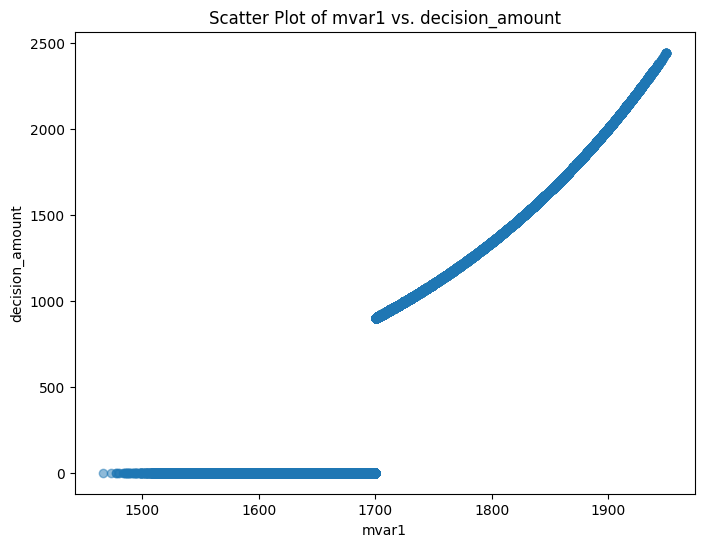

In [ ]:
import matplotlib.pyplot as plt

# Extract the variables for the scatter plot
x = merged_df['mvar1']
y = merged_df['decision_amount']

# Create a scatter plot
plt.figure(figsize=(8, 6))  # Adjust the figure size as needed
plt.scatter(x, y, alpha=0.5)  # alpha controls the transparency of the points

# Set labels and title
plt.xlabel('mvar1')
plt.ylabel('decision_amount')
plt.title('Scatter Plot of mvar1 vs. decision_amount')

# Show the plot
plt.show()


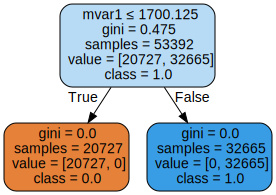

In [ ]:
from sklearn.tree import export_graphviz
import graphviz

# Create and train a decision tree classifier
X = merged_df.drop(columns=['application_key','decision', 'decision_amount'])
y = merged_df['decision']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=242)

# Create the decision tree classifier
decision_tree = DecisionTreeClassifier()  # Adjust the depth as needed

decision_tree.fit(X_train, y_train)

# Visualize the decision tree
dot_data = export_graphviz(decision_tree, out_file=None,
                           feature_names=X.columns,
                           class_names=decision_tree.classes_.astype(str),  # Convert class labels to string
                           filled=True, rounded=True,
                           special_characters=True)

graph = graphviz.Source(dot_data)

# Display the decision tree visualization in the notebook
display(graph)

# 2-b How the firm has determined	how much credit to offer to each consumer

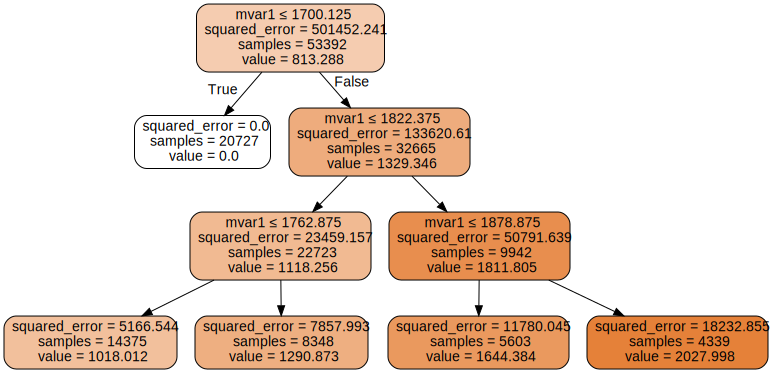

In [ ]:
from sklearn.tree import DecisionTreeRegressor

X = merged_df.drop(columns=['application_key','decision', 'decision_amount'])
y = merged_df['decision_amount']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=242)

# Create and train a Decision Tree regressor
decision_tree = DecisionTreeRegressor(max_depth = 3)  # Adjust parameters as needed
decision_tree.fit(X_train, y_train)


# Visualize the decision tree
dot_data = export_graphviz(decision_tree, out_file=None,
                           feature_names=X.columns,
                           filled=True, rounded=True,
                           special_characters=True)

graph = graphviz.Source(dot_data)

# Display the decision tree visualization in the notebook
display(graph)

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Create bins for the score ranges
score_bins = [0, 1700.1, 1762, 1822, 1878, float('inf')]
score_labels = ['0-1700', '1701-1762', '1763-1822', '1823-1878', '1879+']

# Apply pd.cut to create score range labels for each row
merged_df['score_range'] = pd.cut(merged_df['mvar1'], bins=score_bins, labels=score_labels, right=False)

# Group by score ranges and calculate statistics
score_range_stats = merged_df.groupby('score_range')['decision_amount'].agg(['min', 'max', 'mean', 'median']).reset_index()

# Print the statistics for each score range
print("                 DECISION AMOUNT ACCORDING TO MVAR1          ")
print(score_range_stats)



                 DECISION AMOUNT ACCORDING TO MVAR1          
  score_range          min          max         mean       median
0      0-1700     0.000000     0.000000     0.000000     0.000000
1   1701-1762   898.745588  1149.405349  1016.258067  1012.319995
2   1763-1822  1150.555329  1461.180574  1286.821156  1277.934012
3   1823-1878  1462.642485  1828.040670  1639.204643  1635.984430
4       1879+  1829.869625  2440.601978  2021.430225  2000.195090


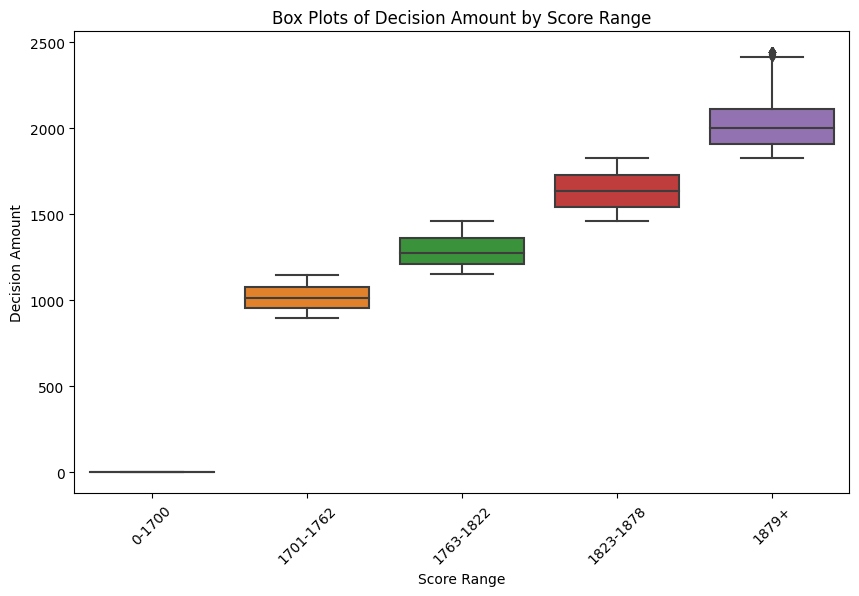

In [ ]:

# Create subplots
fig, ax = plt.subplots(figsize=(10, 6))

# Create a box plot for each score range
sns.boxplot(data=merged_df, x='score_range', y='decision_amount', ax=ax)

# Set labels and title
ax.set_xlabel('Score Range')
ax.set_ylabel('Decision Amount')
ax.set_title('Box Plots of Decision Amount by Score Range')

# Show the plot
plt.xticks(rotation=45)
plt.show()


In [ ]:
import statsmodels.api as sm
filtered_df = merged_df[merged_df['decision'] == 1]
X = filtered_df[['mvar1', 'Age_40-59', 'Gender_M',	'Location_Northern Ireland',	'Location_Scotland',	'Location_Wales']]
X = sm.add_constant(X)  # Add a constant (intercept) to the model
y = filtered_df['decision_amount']
model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:        decision_amount   R-squared:                       0.986
Model:                            OLS   Adj. R-squared:                  0.986
Method:                 Least Squares   F-statistic:                 5.485e+05
Date:                Thu, 26 Oct 2023   Prob (F-statistic):               0.00
Time:                        11:45:22   Log-Likelihood:            -2.4092e+05
No. Observations:               46482   AIC:                         4.818e+05
Df Residuals:                   46475   BIC:                         4.819e+05
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                 

# 3. How credit offered by the firm differs across people will different characteristics (demographics)

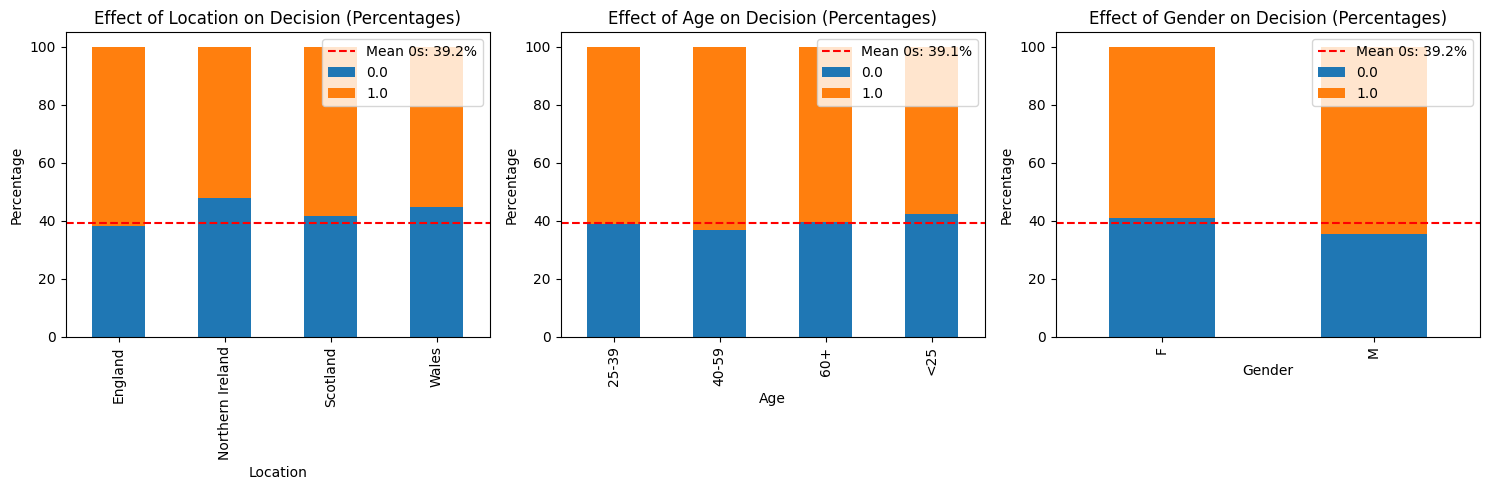

In [ ]:

# Create a list of columns to loop through
columns = ['Location', 'Age', 'Gender']

fig, axs = plt.subplots(1, 3, figsize=(15, 5))  # 1 row, 3 columns for the subplots

for i, column in enumerate(columns):
    contingency_table = pd.crosstab(merged_df_copy[column], merged_df_copy['decision'])
    percentages = contingency_table.div(contingency_table.sum(1), axis=0) * 100

    ax = percentages.plot(kind='bar', stacked=True, ax=axs[i])
    ax.set_title(f"Effect of {column} on Decision (Percentages)")
    ax.set_xlabel(column)
    ax.set_ylabel("Percentage")

    mean_percentage_0 = (percentages[0] * contingency_table[0]).sum() / contingency_table[0].sum()
    ax.axhline(y=mean_percentage_0, color='red', linestyle='--', label=f'Mean 0s: {mean_percentage_0:.1f}%')
    ax.legend()

plt.tight_layout()  # Ensure proper spacing between subplots
plt.show()


In [ ]:
import pandas as pd
from scipy.stats import chi2_contingency
import numpy as np

# Create contingency tables
contingency_tables = {}
demographic_vars = ['Age', 'Location', 'Gender']

for var in demographic_vars:
    contingency_table = pd.crosstab(merged_df_copy[var], merged_df_copy['decision'])
    contingency_tables[var] = contingency_table

results = []

for var, contingency_table in contingency_tables.items():
    chi2, p, dof, expected = chi2_contingency(contingency_table)
    n = np.sum(contingency_table.values)
    cramer_v = np.sqrt(chi2 / (n * min(contingency_table.shape) - 1))  # Cramer's V for contingency tables

    results.append({
        'Demographic Variable': var,
        'Chi-Squared Statistic': chi2,
        'p-value': p,
        "Cramer's V": cramer_v
    })

results_df = pd.DataFrame(results)
print(results_df)


  Demographic Variable  Chi-Squared Statistic       p-value  Cramer's V
0                  Age              73.605537  7.210086e-16    0.021966
1             Location             169.346773  1.760703e-36    0.033318
2               Gender             203.353147  3.873734e-46    0.036511


- AGE: The p-value is highly significant, suggesting a strong association between age and credit decision. The effect size (Cramer's V) is small but indicates a weak association.
- Location: The p-value is highly significant, suggesting a strong association between location and credit decision. The effect size (Cramer's V) indicates a moderate association.
- Gender: The p-value is highly significant, suggesting a strong association between gender and credit decision. The effect size (Cramer's V) shows a moderate association.

In [ ]:
import pandas as pd
import statsmodels.api as sm
from statsmodels.formula.api import ols

filtered_df_copy = merged_df_copy[merged_df_copy['decision'] == 1]


# Fit an ANOVA model for credit amount against demographic variables
model = ols('decision_amount ~ Gender + Location + Age', data=filtered_df_copy).fit()
anova_table = sm.stats.anova_lm(model, typ=2)

print(anova_table)


                sum_sq       df          F        PR(>F)
Gender    7.750088e+06      1.0  58.218517  2.390215e-14
Location  7.377679e+06      3.0  18.473661  5.673040e-12
Age       5.238037e+06      3.0  13.116012  1.476272e-08
Residual  6.186650e+09  46474.0        NaN           NaN


- For "Gender the p-value is very low (< 0.05), indicating that Gender has a significant effect on the decision amount.

- For "Location", the p-value is very low (< 0.05), indicating that Locations have a significant effect on the decision amount.

- For "Age", the p-value is very low (< 0.05), indicating that Age groups have a significant effect on the decision amount.

In [ ]:
import statsmodels.api as sm

X = filtered_df[['mvar1', 'Age_40-59', 'Gender_M',	'Location_Northern Ireland',	'Location_Scotland',	'Location_Wales']]
X = sm.add_constant(X)  # Add a constant (intercept) to the model
y = filtered_df['decision_amount']
model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:        decision_amount   R-squared:                       0.986
Model:                            OLS   Adj. R-squared:                  0.986
Method:                 Least Squares   F-statistic:                 5.485e+05
Date:                Thu, 26 Oct 2023   Prob (F-statistic):               0.00
Time:                        11:26:34   Log-Likelihood:            -2.4092e+05
No. Observations:               46482   AIC:                         4.818e+05
Df Residuals:                   46475   BIC:                         4.819e+05
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                 

The regression model suggests that the independent variables "Age," "Gender," and "Location" have statistically significant effects on "decision_amount." Locations other than England is negatively correlated whereas being male and in age group between 40 and 59 is postively corralated. Finally the model's overall explanatory power (R-squared) is quite high.